In [1]:
import warnings
warnings.filterwarnings("ignore")

# 激活函数绘制

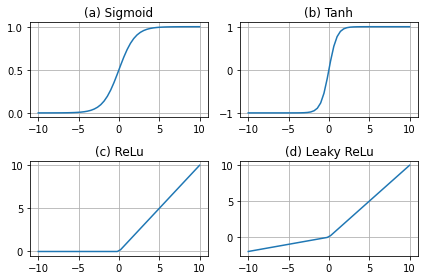

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = np.linspace(-10,10)
y_sigmoid = 1/(1+np.exp(-x))  #sigmoid函数
y_tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))  #tanh函数

fig = plt.figure()
# plot sigmoid
ax = fig.add_subplot(221)
ax.plot(x,y_sigmoid)
ax.grid()
ax.set_title('(a) Sigmoid')

# plot tanh
ax = fig.add_subplot(222)
ax.plot(x,y_tanh)
ax.grid()
ax.set_title('(b) Tanh')

# plot relu
ax = fig.add_subplot(223)
y_relu = np.array([0*item  if item<0 else item for item in x ]) 
ax.plot(x,y_relu)
ax.grid()
ax.set_title('(c) ReLu')

#plot leaky relu
ax = fig.add_subplot(224)
y_relu = np.array([0.2*item  if item<0 else item for item in x ]) 
ax.plot(x,y_relu)
ax.grid()
ax.set_title('(d) Leaky ReLu')
plt.tight_layout()#自动控制间隔


# bp神经网络的python实现

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
def load_data():
    data=pd.read_table("bpdata.txt",sep='	',names=['x1','x2','y'])
    feature=data[['x1','x2']].values #数据特征
    label_tmp=data[['y']] #0,1
    label=np.mat(OneHotEncoder().fit_transform(label_tmp).toarray())
    n_class = label.shape[1]    # 得到类别的个数，2
    return np.mat(feature), label,n_class 

def sig(x):
    '''Sigmoid函数
    input:  x(mat/float):自变量，可以是矩阵或者是任意实数
    output: Sigmoid值(mat/float):Sigmoid函数的值
    '''
    return 1.0 / (1 + np.exp(-x))

def partial_sig(x):
    '''Sigmoid导函数的值
    input:  x(mat/float):自变量，可以是矩阵或者是任意实数
    output: out(mat/float):Sigmoid导函数的值
    '''
    m, n = np.shape(x)
    out = np.mat(np.zeros((m, n)))
    for i in range(m):
        for j in range(n):
            out[i, j] = sig(x[i, j]) * (1 - sig(x[i, j]))
    return out

def hidden_in(feature, w0, b0):
    '''计算隐含层的输入
    input:  feature(mat):特征
            w0(mat):输入层到隐含层之间的权重
            b0(mat):输入层到隐含层之间的偏置
    output: hidden_in(mat):隐含层的输入
    '''
    m = np.shape(feature)[0]#m=400
    hidden_in = feature * w0+b0
    return hidden_in

def hidden_out(hidden_in):
    '''隐含层的输出
    input:  hidden_in(mat):隐含层的输入
    output: hidden_output(mat):隐含层的输出
    '''
    hidden_output = sig(hidden_in)  #sigmoid函数
    return hidden_output;

def predict_in(hidden_out, w1, b1):
    '''计算输出层的输入
    input:  hidden_out(mat):隐含层的输出
            w1(mat):隐含层到输出层之间的权重
            b1(mat):隐含层到输出层之间的偏置
    output: predict_in(mat):输出层的输入
    '''
    m = np.shape(hidden_out)[0]
    predict_in = hidden_out * w1+b1
    return predict_in
    
def predict_out(predict_in):
    '''输出层的输出
    input:  predict_in(mat):输出层的输入
    output: result(mat):输出层的输出
    '''
    result = sig(predict_in)
    return result

def bp_train(feature, label, n_hidden, maxCycle, alpha, n_output):
    '''计算隐含层的输入
    input:  feature(mat):特征
            label(mat):标签
            n_hidden(int):隐含层的节点个数
            maxCycle(int):最大的迭代次数
            alpha(float):学习率
            n_output(int):输出层的节点个数
    output: w0(mat):输入层到隐含层之间的权重
            b0(mat):输入层到隐含层之间的偏置
            w1(mat):隐含层到输出层之间的权重
            b1(mat):隐含层到输出层之间的偏置
    '''
    m, n = np.shape(feature)#400,2
    # 1、初始化
    w0 = np.mat(np.random.rand(n, n_hidden))#2x20,两个输入，20个输出
    b0 = np.mat(np.random.rand(1, n_hidden))#1x20
    w1 = np.mat(np.random.rand(n_hidden, n_output))#20x2    
    b1 = np.mat(np.random.rand(1, n_output))#1x2

    # 2、训练
    i = 0   #迭代次数
    while i <= maxCycle:
        # 2.1、信号正向传播
        # 2.1.1、计算隐含层的输入
        hidden_input = hidden_in(feature, w0, b0)  # mXn_hidden
        # 2.1.2、计算隐含层的输出
        hidden_output = hidden_out(hidden_input)
        # 2.1.3、计算输出层的输入
        output_in = predict_in(hidden_output, w1, b1)  # mXn_output
        # 2.1.4、计算输出层的输出
        output_out = predict_out(output_in)
        
        # 2.2、误差的反向传播
        # 2.2.1、隐含层到输出层之间的残差
        delta_output = -np.multiply((label - output_out), partial_sig(output_in))
        # 2.2.2、输入层到隐含层之间的残差
        delta_hidden = np.multiply((delta_output * w1.T), partial_sig(hidden_input))
        
        # 2.3、 修正权重和偏置       
        w1 = w1 - alpha * (hidden_output.T * delta_output)
        b1 = b1 - alpha * np.sum(delta_output, axis=0) * (1.0 / m)
        w0 = w0 - alpha * (feature.T * delta_hidden)
        b0 = b0 - alpha * np.sum(delta_hidden, axis=0) * (1.0 / m)
        if i % 100 == 0:
            print("\t-------- iter: ", i, " ,cost: ",  (1.0/2) * get_cost(get_predict(feature, w0, w1, b0, b1) - label))                
        i += 1           
    return w0, w1, b0, b1

def get_cost(cost):
    '''计算当前损失函数的值
    input:  cost(mat):预测值与标签之间的差
    output: cost_sum / m (double):损失函数的值
    '''
    m,n = np.shape(cost)
    
    cost_sum = 0.0
    for i in range(m):
        for j in range(n):
            cost_sum += cost[i,j] * cost[i,j]
    return cost_sum / m

def get_predict(feature, w0, w1, b0, b1):
    '''计算最终的预测
    input:  feature(mat):特征
            w0(mat):输入层到隐含层之间的权重
            b0(mat):输入层到隐含层之间的偏置
            w1(mat):隐含层到输出层之间的权重
            b1(mat):隐含层到输出层之间的偏置
    output: 预测值
    '''
    return predict_out(predict_in(hidden_out(hidden_in(feature, w0, b0)), w1, b1))    

    
def err_rate(label, pre):
    '''计算训练样本上的错误率
    input:  label(mat):训练样本的标签
            pre(mat):训练样本的预测值
    output: rate[0,0](float):错误率
    '''
    m = np.shape(label)[0]
    err = 0.0
    for i in range(m):
        if label[i, 0] != pre[i, 0]:
            err += 1
    rate = err / m
    return rate

if __name__ == "__main__":
    #导入数据
    print("--------- 1.load data ------------")
    feature, label, n_class = load_data()#神经元有两个输入，两个输出
    plt.figure(figsize=(8,4),dpi=100)
    feature1=feature[:,0].getA()
    feature2=feature[:,1].getA()
    plt.scatter(feature1[0:200],feature2[0:200],color='b')
    plt.scatter(feature1[200:],feature2[200:],color='r')
    plt.title("original_data")
    
    #训练网络模型
    print("--------- 2.training ------------")
    w0, w1, b0, b1 = bp_train(feature, label, 20, 1000, 0.1, n_class)

    #得到最终的预测结果
    print("--------- 3.get prediction ------------")
    result = get_predict(feature, w0, w1, b0, b1)
    print("训练准确性为：", (1 - err_rate(np.argmax(label, axis=1), np.argmax(result, axis=1))))


--------- 1.load data ------------
--------- 2.training ------------
	-------- iter:  0  ,cost:  0.43068757483848286


D:\conda\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


	-------- iter:  100  ,cost:  0.024810703363097094
	-------- iter:  200  ,cost:  0.02958297163596528
	-------- iter:  300  ,cost:  0.021889724740696524
	-------- iter:  400  ,cost:  0.021627291863088264
	-------- iter:  500  ,cost:  0.020387240625655893
	-------- iter:  600  ,cost:  0.011041856159027707
	-------- iter:  700  ,cost:  0.010811835739303747
	-------- iter:  800  ,cost:  0.010793309196473937
	-------- iter:  900  ,cost:  0.016804344362374223
	-------- iter:  1000  ,cost:  0.010691452707805171
--------- 3.get prediction ------------
训练准确性为： 0.99


In [7]:
feature.shape

(400, 2)

In [11]:
label.shape

(400, 2)

# sklearn中的MLP

## 分类

### 二分类

In [2]:
#分类
from sklearn.neural_network import MLPClassifier
X = [[0., 0.], [1., 1.],[2, 2]]
y = [0, 1, 1]
clf = MLPClassifier(hidden_layer_sizes=(5,2))
clf.fit(X, y)  

D:\conda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [3]:
clf.coefs_  # 列表中的第 i 个元素表示与第 i 层对应的权重矩阵

[array([[-5.00845314e-08, -4.00386066e-01,  7.77377545e-01,
          1.03265895e+00, -3.87021383e-01],
        [ 1.88464143e-05,  1.28017587e-01,  2.68077363e-01,
          8.45007117e-01, -1.00679556e-06]]),
 array([[ 0.02973706,  0.01292502],
        [ 0.21781495,  0.5062895 ],
        [ 0.70020559, -0.61381782],
        [-0.50014469, -0.20747273],
        [ 0.35093713, -0.11673779]]),
 array([[-1.17958151],
        [-1.5258442 ]])]

In [14]:
clf.intercepts_  # 列表中的第 i 个元素表示对应于层 i + 1 的偏差向量

[array([-0.52106182, -0.77387377, -0.70088339,  0.740943  ,  0.45936381]),
 array([-0.60936119, -0.24637518]),
 array([-0.63703736])]

In [5]:
clf.predict_proba([[2., 2.]])  #输出概率

array([[0.37440002, 0.62559998]])

In [12]:
clf.predict([[2., 2.], [-1., -2.]])

array([1, 0])

### 二分类

In [6]:
#分类
from sklearn.neural_network import MLPClassifier
X = [[0., 0.], [1., 1.],[2, 2]]
y = [0, 1, 2]
clf = MLPClassifier(hidden_layer_sizes=(5,2))
clf.fit(X, y)  

D:\conda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [7]:
clf.coefs_

[array([[ 0.8925838 , -0.12720673,  0.2012739 ,  0.61328645,  0.21903055],
        [-0.67865291, -0.48977511,  0.44998043,  0.71544611, -0.01196599]]),
 array([[ 7.49205564e-02, -8.88531561e-01],
        [-3.02580939e-01, -5.62319371e-01],
        [-2.55164261e-06,  7.29646875e-01],
        [-7.28356213e-01,  7.06400815e-01],
        [-3.88045481e-01,  4.12808716e-01]]),
 array([[ 0.67364548,  0.37449451, -0.71522718],
        [-0.28433538, -0.98670168, -0.51823934]])]

In [8]:
clf.intercepts_

[array([-0.44552297,  0.08403195,  0.41848293, -0.39924535,  0.01717207]),
 array([0.05217207, 0.5868602 ]),
 array([-0.77482213, -0.5781877 , -0.56453227])]

In [10]:
clf.predict_proba([[2., 2.]])  #输出概率

array([[0.26625048, 0.4353242 , 0.29842531]])

In [11]:
clf.predict([[2., 2.]])  #输出概率

array([1])

## 回归

In [8]:
#回归
from sklearn.neural_network import MLPRegressor
X = [[0., 0.], [1., 1.],[2, 2]]
y = [0, 1, 2]#输出一个
clf = MLPRegressor(hidden_layer_sizes=(5, 2))
clf.fit(X, y)

D:\conda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(5, 2), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [13]:
clf.coefs_

[array([[ 0.21724315,  0.74511989, -0.77552676, -0.16514847, -0.52992443],
        [ 0.56218905, -0.69635582, -0.40744851, -0.07008052, -0.26403128]]),
 array([[ 0.17671108,  0.20635234],
        [ 0.46387954,  0.60549976],
        [-0.32881676,  0.72777788],
        [ 0.70730329,  0.60201498],
        [-0.72634631,  0.18963482]]),
 array([[-0.50594089],
        [-0.78725898]])]

# 葡萄酒分类

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
data = np.genfromtxt('wine_data.csv', delimiter=',')
data

array([[1.000e+00, 1.423e+01, 1.710e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.000e+00, 1.320e+01, 1.780e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.000e+00, 1.316e+01, 2.360e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [3.000e+00, 1.327e+01, 4.280e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [3.000e+00, 1.317e+01, 2.590e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [3.000e+00, 1.413e+01, 4.100e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]])

In [12]:
data.shape

(178, 14)

In [13]:
x_data=data[:,1:]#数据特征
x_data

array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]])

In [14]:
y_data=data[:,0]  #标签
y_data

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3.])

In [16]:
import pandas as pd
pd.Series(y_data).value_counts()

2.0    71
1.0    59
3.0    48
dtype: int64

In [15]:
train_test_split?

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,stratify=y_data)#分为训练和测试

In [23]:
import pandas as pd
pd.Series(y_train).value_counts()

2.0    53
1.0    44
3.0    36
dtype: int64

In [24]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)#标准化处理
x_test = scaler.transform(x_test)

In [25]:
x_train.shape

(133, 13)

In [27]:
mlp = MLPClassifier(hidden_layer_sizes=(20))
mlp.fit(x_train, y_train)

D:\conda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=20, learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [28]:
mlp.score(x_test,y_test)

0.9777777777777777

## 参数优化

In [30]:
from sklearn.model_selection import GridSearchCV

In [34]:
mlp = MLPClassifier(max_iter=500)
params={'hidden_layer_sizes':[(10,),(30,),(100,)],'alpha':[0.000001,0.00001,0.0001]}
grid_search=GridSearchCV(mlp,param_grid=params,cv=10,verbose=2,n_jobs=-1)
grid_search.fit(x_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.5s finished
D:\conda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=500,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001],
         

In [35]:
grid_search.best_params_

{'alpha': 1e-06, 'hidden_layer_sizes': (100,)}

In [36]:
grid_search.score(x_test,y_test)

0.9777777777777777